In [1]:
from __future__ import print_function
import os
import sys

# Edit this to be the full path to the extracted Spark directory on your computer
spark_home = 'C:\Users\mcollins\Desktop\SparkWorkshop\spark-1.6.1-bin-hadoop2.6'

os.environ['SPARK_HOME'] = spark_home
sys.path.insert(0, spark_home + "/python")
sys.path.insert(0, os.path.join(spark_home, 'python\lib\py4j-0.9-src.zip'))

In [2]:
from pyspark.context import SparkContext
from pyspark.sql import SQLContext
sc = SparkContext()
sqlContext = SQLContext(sc)

In [3]:
comments = sqlContext.read.json("data/hacker_news_small.json")
comments.count()

102

In [4]:
comments.printSchema()

root
 |-- _highlightResult: struct (nullable = true)
 |    |-- author: struct (nullable = true)
 |    |    |-- matchLevel: string (nullable = true)
 |    |    |-- matchedWords: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)
 |    |    |-- value: string (nullable = true)
 |    |-- comment_text: struct (nullable = true)
 |    |    |-- matchLevel: string (nullable = true)
 |    |    |-- matchedWords: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)
 |    |    |-- value: string (nullable = true)
 |    |-- story_title: struct (nullable = true)
 |    |    |-- matchLevel: string (nullable = true)
 |    |    |-- matchedWords: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)
 |    |    |-- value: string (nullable = true)
 |    |-- story_url: struct (nullable = true)
 |    |    |-- matchLevel: string (nullable = true)
 |    |    |-- matchedWords: array (nullable = true)
 |    |    |    |-- elemen

In [5]:
comments.show(3)


+--------------------+--------------------+----------+--------------------+--------------------+------------+------------+--------+---------+------+--------+----------+--------------------+--------------------+-----+----+
|    _highlightResult|               _tags|    author|        comment_text|          created_at|created_at_i|num_comments|objectID|parent_id|points|story_id|story_text|         story_title|           story_url|title| url|
+--------------------+--------------------+----------+--------------------+--------------------+------------+------------+--------+---------+------+--------+----------+--------------------+--------------------+-----+----+
|[[none,WrappedArr...|[comment, author_...|       VMG|Because you don&#...|2014-05-30T08:19:34Z|  1401437974|        null| 7820767|  7820656|     1| 7820350|      null|Mark Zuckerberg a...|http://www.mercur...| null|null|
|[[none,WrappedArr...|[comment, author_...|hackerboos|$649 in US<p>$699...|2014-05-30T08:18:47Z|  1401437927|   

In [6]:
comments.select(comments["comment_text"]).show(3)

+--------------------+
|        comment_text|
+--------------------+
|Because you don&#...|
|$649 in US<p>$699...|
|The one I use mos...|
+--------------------+
only showing top 3 rows



The above line is a good oportunity to look at the documentation:

https://spark.apache.org/docs/1.6.1/api/python/pyspark.sql.html

show() is in the DataFrame functions. Or search for "show(n=20" because the show() function is used in a lot of examples.

This is also a good time to introduce the line continuation character "\" which makes reading long commands easier.

In [7]:
comments\
    .select(comments["comment_text"])\
    .show(3, truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|comment_text                                                                                                                                                                                                                                                                                                                                                                                              |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Cleaning

From the sample comments, we can see that if we are going to look at what words are in the comments, we will need to remove the HTML tags and we will need to convert HTML entities like "&#x27;" to their characters like "'". There are a number of libraries we could use to do that but we will work with just do a regular expression because Spark is the focus for today.

In [9]:
import re
expression = re.compile(r'<.*?>')
import HTMLParser
parser = HTMLParser.HTMLParser()

def strip_tags(html):
    return parser.unescape(
        expression.sub('', html)
        )
    
print(strip_tags("<b>you&#x27;re a Gator!</b>"))

you're a Gator!


That's a nice little function but how do we run it on a column in the dataframe? And where do we store the results? What we want to do is add a column to the dataframe with text that has no HTML in it. This is called applying a user defined function to your data.

In [10]:
comments_clean = comments.withColumn("comment_clean", 
                                     strip_tags(comments["comment_text"])
                                    )

TypeError: expected string or buffer

Whoops! That didn't work. We wrote a Python function that takes a string and passed it a Spark dataframe column. What we want is to get Spark to do is to run that function for every value in the column with means we have to change our function to something Spark knows how to handle. Fortunately, there's a function to do just that. Notice that the argument to udf() is a function and the return is a function. In Python, functins are first class objects, they're a thing that can be manuipulated, calculated, returned, etc. like other data types.

In [11]:
from pyspark.sql.functions import udf

strip_tags_udf = udf(strip_tags)

comments_clean = comments.withColumn("comment_clean", 
                                     strip_tags_udf(comments["comment_text"])
                                    )

In [12]:
comments_clean\
    .select(comments_clean["comment_clean"])\
    .show(3, truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|comment_clean                                                                                                                                                                                                                                                                                                                       |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Because you don't 

# Tokenizing

Today we're going to do some very simple NLP. We'll consider the comments to just be a collection of words. We'll use those words to figure out which posts are most relavent to a search term that we're interested in.

First up is splitting the comments up in to lists of words. At this point we'll introduce the machine learning API:

(Mention ml vs mllib)

https://spark.apache.org/docs/1.6.1/api/python/pyspark.ml.html


In [13]:
from pyspark.ml.feature import Tokenizer
tokenizer = Tokenizer(inputCol="comment_clean", outputCol="words")

comments_words = tokenizer.transform(comments_clean)

In [14]:
comments_words\
    .select(comments_words["words"])\
    .show(3, truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|words                                                                                                                                                                                                                                                                                                                                                                                             |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [15]:
# What are the stop words? http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words

from pyspark.ml.feature import StopWordsRemover
stopWordsRemover = StopWordsRemover(inputCol="words", outputCol="tokens")

comments_tokens = stopWordsRemover.transform(comments_words)

In [16]:
comments_tokens\
    .select(comments_tokens["tokens"])\
    .show(3, truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|tokens                                                                                                                                                                                                                                                  |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[don't, rely, political, apparatus, spend, money, wisely.by, way,, wait, billionaires, anywhere,, want, help, education,, it.]                                                                                                                        

# Zipf's Law

Zipf's law says that the frequency of a term is inversely proportianal to it's rank ie. the second most common term occurs 1/2 as often as the first; the third most common 1/3 as often; etc.

Let's count our tokens and graph the counts to see what they look like. Here we're going to use a map-reduce pattern of computation which we're going to express in dataframe functions that look like a SQL statement.

In [17]:
from pyspark.sql.functions import explode

tokens = comments_tokens\
    .select(explode(comments_tokens["tokens"]).alias("token"))\
    .groupBy("token")\
    .count()\
    .orderBy("count", ascending=False)
    
tokens.show(3)

+-----+-----+
|token|count|
+-----+-----+
|     |   47|
| like|   22|
| it's|   19|
+-----+-----+
only showing top 3 rows



Now how do we graph the frequency against term rank (integer sequence from 1..n)? We have a Spark dataframe but that's not something we can use with graphing tools. But, we can convert it to Pandas.

We'll convert the absolute minimum information to a Pandas dataframe - storage, transfer time.

In [18]:
tokens_pdf = tokens\
    .select(tokens["count"])\
    .toPandas()

In [19]:
tokens_pdf.count()

count    2027
dtype: int64

In [20]:
tokens_pdf["rank"] = range(1, tokens_pdf.shape[0] + 1)
tokens_pdf.head()

,count,rank
0,47,1
1,22,2
2,19,3
3,19,4
4,18,5


In [21]:
%matplotlib inline

# "conda install seaborn" at a command prompt if you don't have it already
import seaborn as sns

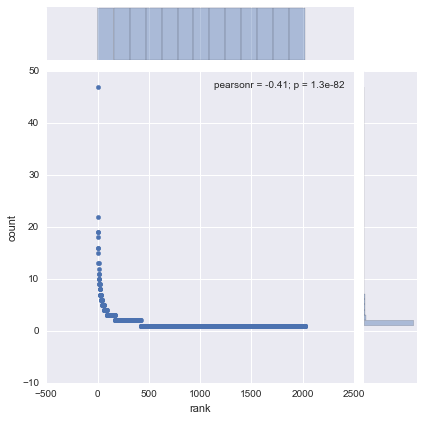

In [22]:
sns.jointplot(x="rank", y="count", data=tokens_pdf)

# TF-IDF Searching

Gave up on this since it turned in to a lot of typing and drifted towards fiddly magic data structure manipulation.


In [39]:
from pyspark.ml.feature import HashingTF

tf = HashingTF(inputCol="tokens", outputCol="tf")

comments_tf = tf.transform(comments_tokens)

In [40]:
comments_tf\
    .select(comments_tf["tf"])\
    .show(3, truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|tf                                                                                                                                                                                                                                                                                                                          |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|(262144,[8384,48893,53057,65886,83376,8883

In [44]:
from pyspark.ml.feature import IDF

idf = IDF(inputCol="tf", outputCol="idf")
comments_idf = idf.fit(comments_tf).transform(comments_tf)

In [45]:
comments_idf\
    .select(comments_idf["idf"])\
    .show(3, truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|idf                                                                                                                                                                                                                                                        

In [ ]:
comments_idf.select()

In [48]:
x = [3, 5, 4]
y = [5, 6, 7]
[a*b for a, b in zip(x, y)]

[15, 30, 28]